# Cell type differences in PBMCs

### Load the data

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/demux/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the data

In [6]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells', 'Dendritic cells', 'Megakaryocytes']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B', 'DC', 'Mega']))

In [7]:
def simplify_name(name):
    return name.split('.')[0]

In [8]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
# temp_adata = adata.copy()
# temp_adata = temp_adata[temp_adata.obs.cell == ct].copy()
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

In [10]:
adata.obs['ct'] = adata.obs['cell'].apply(lambda x: label_converter[x])

In [11]:
adata.shape

(24495, 35635)

In [12]:
adata.obs.cell.value_counts()

CD4 T cells          10342
CD14+ Monocytes       5341
B cells               2564
CD8 T cells           2035
NK cells              1988
FCGR3A+ Monocytes     1586
Dendritic cells        432
Megakaryocytes         207
Name: cell, dtype: int64

In [13]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

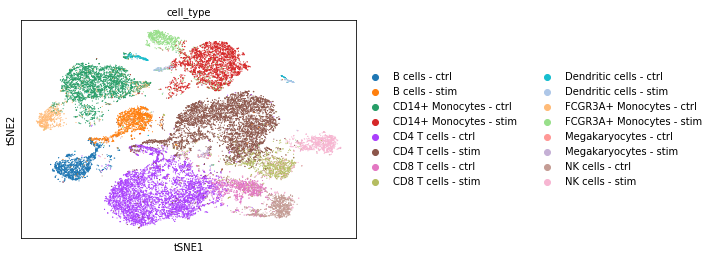

In [14]:
sc.pl.tsne(adata, color='cell_type')

In [15]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [16]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [17]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Read TFs

In [18]:
tf_df = pd.read_csv('../ifn_hbec/version3/baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Select control cells

In [208]:
cts = ['Th', 'cM']

In [209]:
ctrl_adata = adata[
    adata.obs['ct'].isin(cts) & \
    adata.obs['stim'].isin(['ctrl'])].copy().copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Setup memento

In [210]:
ctrl_adata.obs['q'] = 0.07

In [211]:
ctrl_adata.X = ctrl_adata.X.astype(float)

In [212]:
memento.setup_memento(ctrl_adata, q_column='q', trim_percent=0.1, filter_mean_thresh=0.07)

Version 0.0.6


### Get highly expressed TFs

### Test variability

In [213]:
simplified_cts = ['T', 'B', 'M']
for ct in ['Th']:
    print(ct)
    
    labeled_ctrl_adata = ctrl_adata.copy().copy()
    labeled_ctrl_adata.obs['is_ct'] = labeled_ctrl_adata.obs['ct'].str.contains(ct).astype(int)
    
    memento.create_groups(labeled_ctrl_adata, label_columns=['is_ct', 'ind', 'ct'])
    
    memento.compute_1d_moments(labeled_ctrl_adata, min_perc_group=.7)
    
    memento.ht_1d_moments( 
        labeled_ctrl_adata, 
        formula_like='1 + is_ct + ind',
        treatment_col='is_ct', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    labeled_ctrl_adata.write(data_path + 'ct_var/Th_vs_cM.h5ad'.format(ct))

Th


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    9.1s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   14.8s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   22.2s
[Parallel(n_jobs=94)]: Done 1298 out of 1298 | elapsed:   27.4s finished
... storing 'memento_group' as categorical


### Cytokine

In [214]:
m_df, v_df = memento.get_1d_moments(labeled_ctrl_adata, groupby='ct')

In [215]:
cytokines = pd.read_csv('mart_export.txt')['Gene name'].tolist()

In [216]:
v_df['is_cytokine'] = v_df['gene'].isin(cytokines)

In [217]:
v_long_df = pd.melt(v_df, id_vars='gene', value_vars=['ct_cM', 'ct_Th'])
v_long_df['is_cytokine'] = v_long_df['gene'].isin(cytokines)

In [218]:
v_long_df.head(5)

,gene,variable,value,is_cytokine
0,ISG15,ct_cM,3.117775,False
1,SDF4,ct_cM,-0.291893,False
2,AURKAIP1,ct_cM,-0.646131,False
3,MRPL20,ct_cM,-0.443631,False
4,SSU72,ct_cM,0.008626,False


([<matplotlib.axis.XTick at 0x7fdc6eb49cd0>,
 [Text(0, 0, 'cM'), Text(1, 0, 'Th')])

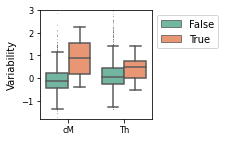

In [219]:
plt.figure(figsize=(2,2))
sns.boxplot(x='variable', y='value', hue='is_cytokine', data=v_long_df, palette='Set2', fliersize=0.1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.ylim(-1.8, 3)
plt.xlabel(None); plt.ylabel('Variability')
plt.xticks([0, 1], ['cM', 'Th'])
# plt.savefig('figures/cytokine.pdf', bbox_inches='tight')

### Variability result

In [247]:
ht_df = memento.get_1d_ht_result(labeled_ctrl_adata)
ht_df['dv_fdr'] = memento.util._fdrcorrect(ht_df['dv_pval'])
ht_df['de_fdr'] = memento.util._fdrcorrect(ht_df['de_pval'])

In [248]:
ht_df['is_cytokine'] = ht_df['gene'].isin(cytokines)

In [249]:
cyto_ht_df = ht_df.query('is_cytokine')

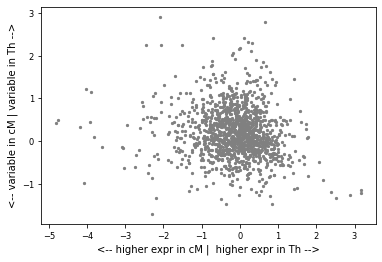

In [268]:
plt.scatter(ht_df['de_coef'], ht_df['dv_coef'], s=5, color='grey')
plt.xlabel('<-- higher expr in cM |  higher expr in Th -->')
plt.ylabel('<-- variable in cM | variable in Th -->')
plt.savefig('figures/Th_cM_scatter.png', bbox_inches='tight', dpi=800)

In [251]:
m_df['is_cytokine'] = m_df['gene'].isin(cytokines)

In [252]:
merged = ht_df.merge(m_df, on='gene')
merged['is_cytokine'] = merged['gene'].isin(cytokines)

In [269]:
merged.sort_values('de_coef', ascending=True).head(50)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr,is_cytokine_x,ct_cM,ct_Th,is_cytokine_y,is_cytokine
450,HLA-DRA,-4.809106,0.044393,1.519470e-08,0.419323,0.067397,4.092803e-04,0.003638,8.825788e-07,False,2.181193,-2.666383,False,False
565,TIMP1,-4.751873,0.036206,1.303506e-08,0.483631,0.040236,3.204262e-06,0.000198,8.825788e-07,True,3.340123,-1.453159,True,True
820,CD63,-4.174629,0.035240,2.962145e-06,0.328875,0.040092,5.541518e-05,0.001042,1.501900e-05,False,1.964265,-2.270235,False,False
487,SOD2,-4.070740,0.050659,6.120528e-08,-0.988269,0.111669,2.556676e-05,0.000603,1.690307e-06,False,2.089109,-1.968148,False,False
1241,FTL,-4.027495,0.030579,2.106232e-06,1.209837,0.049422,9.808241e-07,0.000098,1.209686e-05,False,5.095597,1.060026,False,False
104,S100A4,-3.934628,0.041014,1.396171e-07,0.455250,0.101018,2.308199e-04,0.002586,2.552436e-06,False,1.779185,-2.158198,False,False
1267,LGALS1,-3.890944,0.035494,3.959486e-08,1.162612,0.039562,1.790901e-06,0.000145,1.352477e-06,False,1.798068,-2.149105,False,False
918,LGALS3,-3.828302,0.043933,7.484216e-06,0.087166,0.045320,5.229477e-02,0.153920,2.719684e-05,False,1.660231,-2.253565,False,False
344,ANXA5,-3.612087,0.037035,1.204823e-08,-0.130233,0.043348,2.399760e-03,0.012510,8.825788e-07,False,1.692891,-1.990407,False,False
271,GPX1,-3.089924,0.039539,1.454792e-05,-0.129324,0.041470,1.699830e-03,0.009806,4.301413e-05,False,1.038275,-2.110768,False,False


In [257]:
merged.sort_values('de_coef', ascending=False)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr,is_cytokine_x,ct_cM,ct_Th,is_cytokine_y,is_cytokine
441,LTB,3.157061,0.043587,9.047624e-06,-1.148956,0.126753,1.159466e-05,0.000334,3.054977e-05,True,-2.696561,0.523550,True,True
1065,CCR7,3.156679,0.048607,2.544713e-08,-1.226637,0.098357,8.645385e-07,0.000094,1.065496e-06,True,-2.653374,0.584560,True,True
551,GIMAP7,2.879219,0.041234,1.033628e-08,-1.253244,0.093833,5.647460e-06,0.000244,8.825788e-07,False,-2.376428,0.490213,False,False
802,LDHB,2.505959,0.037432,2.795154e-07,-1.326152,0.085729,3.960115e-06,0.000214,3.731733e-06,False,-2.292187,0.277441,False,False
359,IL7R,2.392936,0.050900,7.281894e-08,-1.193199,0.121445,1.592065e-05,0.000415,1.890380e-06,True,-2.704709,-0.292855,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,FTL,-4.027495,0.030579,2.106232e-06,1.209837,0.049422,9.808241e-07,0.000098,1.209686e-05,False,5.095597,1.060026,False,False
487,SOD2,-4.070740,0.050659,6.120528e-08,-0.988269,0.111669,2.556676e-05,0.000603,1.690307e-06,False,2.089109,-1.968148,False,False
820,CD63,-4.174629,0.035240,2.962145e-06,0.328875,0.040092,5.541518e-05,0.001042,1.501900e-05,False,1.964265,-2.270235,False,False
565,TIMP1,-4.751873,0.036206,1.303506e-08,0.483631,0.040236,3.204262e-06,0.000198,8.825788e-07,True,3.340123,-1.453159,True,True


In [256]:
merged.query('dv_fdr < 0.1 & de_coef < 0 & de_fdr < 0.1 & dv_coef < 0')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr,is_cytokine_x,ct_cM,ct_Th,is_cytokine_y,is_cytokine
0,ISG15,-0.911107,0.099141,5.105429e-05,-0.730204,0.236485,5.799420e-03,0.025009,1.060295e-04,False,-0.371517,-1.504636,False,False
7,PARK7,-0.201619,0.039294,7.484128e-04,-1.030647,0.326971,3.499650e-03,0.016639,1.045683e-03,False,-0.715792,-0.881617,False,False
40,MARCKSL1,-2.722199,0.036485,8.206917e-08,-0.331681,0.057274,9.953490e-05,0.001538,1.972700e-06,False,1.104084,-1.602502,False,False
51,CAP1,-0.770212,0.037554,1.391437e-06,-0.483053,0.133321,1.599840e-03,0.009396,9.175070e-06,False,-0.647183,-1.414041,False,False
54,YBX1,-0.500579,0.023260,8.794473e-07,-0.277671,0.073699,5.364932e-04,0.004153,6.965588e-06,False,0.694056,0.150381,False,False
131,ARPC5,-1.353933,0.031896,1.339794e-05,-0.438587,0.074789,1.074662e-04,0.001641,4.058619e-05,False,0.574174,-0.775383,False,False
156,PDIA6,-0.706612,0.051865,1.589504e-05,-0.484671,0.153358,2.999700e-03,0.014861,4.564548e-05,False,-1.154890,-1.881839,False,False
181,ACTR2,-1.261066,0.058858,1.619660e-06,-0.744177,0.202636,2.399760e-03,0.012510,1.015613e-05,False,-1.119803,-2.406656,False,False
233,BZW1,-0.288820,0.062939,1.320363e-03,-0.814607,0.257767,5.499450e-03,0.023874,1.768660e-03,False,-1.700324,-2.051013,False,False
241,ARPC2,-1.182281,0.024453,1.136190e-07,-0.144464,0.064168,2.269773e-02,0.079842,2.244813e-06,False,1.253618,0.061215,False,False


In [270]:
for g in merged.query('dv_fdr < 0.1 & de_coef > 0 & de_fdr < 0.1 & dv_coef > 0').gene.tolist():
    print(g)

HNRNPR
NUDC
YTHDF2
PRPF38B
BCAS2
TXNIP
CACYBP
RGS2
CD55
YPEL5
SRSF7
DUSP2
EIF5B
WDR33
PPIG
HNRNPA3
ZC3H15
HSPD1
HSPE1
SETD5-AS1
CNBP
G3BP2
RPL37
GPBP1
UBE2B
HSPA9
MATR3
NDFIP1
MRPL22
HIST1H2AC
HLA-A
SRSF3
HSP90AB1
EEF1A1
EZR
TCP1
MRPL18
CYCS
SYAP1
WHSC1L1
PABPC1
EEF1D
RPL12
NTMT1
EPC1
CREM
AIP
MRPL21
CHORDC1
BIRC3
HSPA8
CLEC2B
KRAS
RSRC2
UBC
HSPH1
GPR183
FAM177A1
C14orf166
AHSA1
CYLD
TERF2IP
EIF5A
RPL26
EVI2A
CCL5
LUC7L3
PSMC5
SRSF2
IDH3B
RBM39
GADD45B
RPS28
DNAJB1
FAM32A
TBCB
EIF3K
ZFP36
RPS16
RPS9
RANBP1
ST13


In [227]:
merged = ht_df.merge(m_df, on='gene')

In [228]:
merged.query('gene == "HSPB1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,is_cytokine_x,ct_cM,ct_Th,is_cytokine_y
524,HSPB1,-0.008171,0.078496,0.917408,2.191577,0.182598,0.000016,0.000415,False,-0.858947,-0.918263,False


In [229]:
pd.Series(ctrl_adata[ctrl_adata.obs.ct == 'Th', 'IRF1'].X.todense().A1).value_counts()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0.0    4590
1.0     482
2.0      51
3.0      12
4.0       7
dtype: int64

(array([4.98e+03, 8.90e+01, 3.60e+01, 1.40e+01, 1.10e+01, 6.00e+00,
        2.00e+00, 1.00e+00, 0.00e+00, 3.00e+00]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

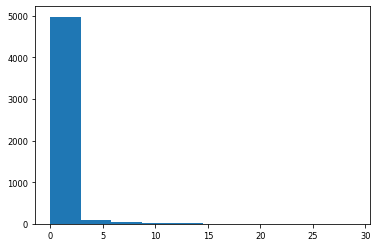

In [230]:
plt.hist(ctrl_adata[ctrl_adata.obs.ct == 'Th', 'CCL5'].X.todense().A1)

In [231]:
a = pd.DataFrame()
a['expr'] = ctrl_adata[ctrl_adata.obs.ct == 'Th', 'LTB'].X.todense().A1
a['ct'] = 'Th'
b = pd.DataFrame()
b['expr'] = ctrl_adata[ctrl_adata.obs.ct == 'Th', 'CCL5'].X.todense().A1
b['ct'] = 'cM'
c = pd.concat([a,b])

In [243]:
pre_res = gp.prerank(rnk=merged.sort_values('de_coef', ascending=False)[['gene','dv_coef']], gene_sets='GO_Molecular_Function_2018',
                     processes=4,
                     permutation_num=100)

In [244]:
pre_res.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
double-stranded RNA binding (GO:0003725),0.684911,1.708974,0.000000,0.020707,60,15,HSP90AB1;MSN;OASL;HSPD1;MTDH;LRRFIP1;TUBB4B;DD...,HSP90AB1;MSN;OASL;HSPD1;MTDH;LRRFIP1;TUBB4B;DD...
adenyl ribonucleotide binding (GO:0032559),0.601076,1.668838,0.000000,0.036237,280,21,HSPA1A;HSP90AB1;HSPH1;HSPA9;HSPA8;HSP90AA1;EIF...,HSPA1A;HSP90AB1;HSPH1;HSPA9;HSPA8;HSP90AA1
ATP binding (GO:0005524),0.609405,1.583578,0.000000,0.072474,256,20,HSPA1A;HSP90AB1;HSPH1;HSPA9;HSPA8;HSP90AA1;EIF...,HSPA1A;HSP90AB1;HSPH1;HSPA9;HSPA8;HSP90AA1
ubiquitin protein ligase binding (GO:0031625),0.493302,1.557542,0.010638,0.075925,285,63,HSPA1A;UBC;TCP1;DNAJA1;UBE2B;HSPA9;HSPA8;TXNIP...,HSPA1A;UBC;TCP1;DNAJA1;UBE2B;HSPA9;HSPA8;TXNIP...
ubiquitin-protein transferase activity (GO:0004842),0.543817,1.591387,0.000000,0.077650,418,28,WSB1;UBE2B;ANAPC11;TANK;UBE2D3;TNFAIP3;RNF181;...,WSB1;UBE2B;ANAPC11;TANK;UBE2D3;TNFAIP3;RNF181;...
ubiquitin-like protein ligase binding (GO:0044389),0.493302,1.607774,0.000000,0.079376,298,63,HSPA1A;UBC;TCP1;DNAJA1;UBE2B;HSPA9;HSPA8;TXNIP...,HSPA1A;UBC;TCP1;DNAJA1;UBE2B;HSPA9;HSPA8;TXNIP...
RNA polymerase II core promoter proximal region sequence-specific DNA binding (GO:0000978),0.566954,1.532522,0.012048,0.082827,263,21,SKIL;JUNB;KLF6;JUN;NR1H2;STAT3;H2AFZ;LRRFIP1;A...,SKIL;JUNB;KLF6;JUN;NR1H2;STAT3;H2AFZ;LRRFIP1
core promoter proximal region sequence-specific DNA binding (GO:0000987),0.566954,1.468780,0.037037,0.165654,279,21,SKIL;JUNB;KLF6;JUN;NR1H2;STAT3;H2AFZ;LRRFIP1;A...,SKIL;JUNB;KLF6;JUN;NR1H2;STAT3;H2AFZ;LRRFIP1
transcription corepressor activity (GO:0003714),0.533024,1.440565,0.012195,0.190962,204,23,DNAJB1;HSPA1A;SRSF2;JUNB;SAP18;CIR1;EID1;YY1;H...,DNAJB1;HSPA1A;SRSF2;JUNB


In [176]:
merged.query('dv_fdr < 0.1 & (de_coef < 0.15 & de_coef > -0.15) & dv_coef > 0.5').sort_values('ct_cM', ascending=False)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,is_cytokine_x,ct_cM,ct_Th,is_cytokine_y
756,FAU,-0.116202,0.015344,0.000013,0.659671,0.189193,0.003400,0.016652,False,1.165827,1.047264,False
1024,COX4I1,-0.085277,0.020347,0.000539,0.774246,0.134529,0.000260,0.002626,False,0.689469,0.614227,False
1048,UBB,-0.035385,0.028939,0.219678,2.150409,0.097443,0.000002,0.000130,False,0.607214,0.550536,False
1221,EIF3K,0.142811,0.032227,0.001106,0.968079,0.199028,0.000809,0.005793,False,-0.567188,-0.425663,False
524,HSPB1,-0.008171,0.078020,0.913709,2.191577,0.181109,0.000002,0.000164,False,-0.858947,-0.918263,False
21,C1orf63,-0.081416,0.041032,0.046195,0.932903,0.272593,0.002900,0.014760,False,-0.985168,-1.111213,False
58,UQCRH,-0.096267,0.040634,0.018898,1.119635,0.407641,0.012099,0.046600,False,-1.010268,-1.109671,False
236,SUMO1,-0.068766,0.041147,0.095590,0.750512,0.209177,0.002000,0.010816,False,-1.021138,-1.090818,False
65,JUN,-0.147872,0.062124,0.016498,1.038949,0.155893,0.000091,0.001392,False,-1.153134,-1.337985,False
224,HNRNPA3,0.101717,0.045082,0.023498,0.637469,0.198820,0.004200,0.019538,False,-1.207582,-1.099868,False
